In [1]:
# CÉLULA 1: SIMULAÇÃO E PREPARAÇÃO DE DADOS

# Instala as bibliotecas necessárias
!pip install --upgrade pmcx numpy matplotlib jdata

import pmcx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# --- Configurações de Simulação ---
voxel_size_mm = 0.05
nphotons = 1e8
wavelengths = [660, 808, 830]
fototipos_simular = ["I", "II", "III", "IV", "V", "VI"]

epidermis_thicknesses_voxels = [1, 3, 12] # 50um, 150um, 600um
epidermis_thicknesses_mm = [et * voxel_size_mm for et in epidermis_thicknesses_voxels]

dermis_thickness_voxels = 30
hypodermis_thickness_voxels = 100
# muscle_thickness_voxels foi removido pois o músculo agora vai até o fim

total_size_xy = 240
total_size_z = 180 # Tamanho total do eixo Z em voxels

# --- Configurações de Amostragem (para Plots) ---
center_slice = total_size_xy // 2
x_slice_start = 110
x_slice_end = 130
y_slice_start = 110
y_slice_end = 130

# --- Função auxiliar: propriedades ópticas por λ e fototipo (Inalterada) ---
def get_props(wavelength_nm, fototipo="III"):
    muscle_props = {}
    if wavelength_nm == 660:
        muscle_props = [0.04, 15.0, 0.90, 1.39]
    elif wavelength_nm == 808:
        muscle_props = [0.03, 12.0, 0.90, 1.39]
    elif wavelength_nm == 830:
        muscle_props = [0.03, 11.5, 0.90, 1.39]
    else:
        raise ValueError(f"Comprimento de onda {wavelength_nm} nm não configurado para Músculo!")

    if fototipo == "I":
        if wavelength_nm == 660:
            return [[0, 0, 1, 1], [0.03, 38, 0.8, 1.37], [0.045, 2.7, 0.77, 1.37], [0.012, 1.3, 0.8, 1.37], muscle_props]
        elif wavelength_nm == 808:
            return [[0, 0, 1, 1], [0.015, 25, 0.8, 1.37], [0.022, 2.3, 0.77, 1.37], [0.009, 1.2, 0.8, 1.37], muscle_props]
        elif wavelength_nm == 830:
            return [[0, 0, 1, 1], [0.013, 24, 0.8, 1.37], [0.020, 2.2, 0.77, 1.37], [0.008, 1.1, 0.8, 1.37], muscle_props]
    elif fototipo == "II":
        if wavelength_nm == 660:
            return [[0, 0, 1, 1], [0.04, 38, 0.8, 1.37], [0.048, 2.6, 0.77, 1.37], [0.0125, 1.25, 0.8, 1.37], muscle_props]
        elif wavelength_nm == 808:
            return [[0, 0, 1, 1], [0.020, 25, 0.8, 1.37], [0.024, 2.2, 0.77, 1.37], [0.0095, 1.15, 0.8, 1.37], muscle_props]
        elif wavelength_nm == 830:
            return [[0, 0, 1, 1], [0.017, 24, 0.8, 1.37], [0.021, 2.1, 0.77, 1.37], [0.0085, 1.05, 0.8, 1.37], muscle_props]
    elif fototipo == "III":
        if wavelength_nm == 660:
            return [[0, 0, 1, 1], [0.06, 38, 0.8, 1.37], [0.05, 2.5, 0.77, 1.37], [0.013, 1.2, 0.8, 1.37], muscle_props]
        elif wavelength_nm == 808:
            return [[0, 0, 1, 1], [0.03, 25, 0.8, 1.37], [0.025, 2.1, 0.77, 1.37], [0.010, 1.1, 0.8, 1.37], muscle_props]
        elif wavelength_nm == 830:
            return [[0, 0, 1, 1], [0.027, 24, 0.8, 1.37], [0.022, 2.0, 0.77, 1.37], [0.009, 1.0, 0.8, 1.37], muscle_props]
    elif fototipo == "IV":
        if wavelength_nm == 660:
            return [[0, 0, 1, 1], [0.09, 38, 0.8, 1.37], [0.052, 2.4, 0.77, 1.37], [0.0135, 1.15, 0.8, 1.37], muscle_props]
        elif wavelength_nm == 808:
            return [[0, 0, 1, 1], [0.045, 25, 0.8, 1.37], [0.026, 2.0, 0.77, 1.37], [0.0105, 1.05, 0.8, 1.37], muscle_props]
        elif wavelength_nm == 830:
            return [[0, 0, 1, 1], [0.040, 24, 0.8, 1.37], [0.023, 1.9, 0.77, 1.37], [0.0095, 0.95, 0.8, 1.37], muscle_props]
    elif fototipo == "V":
        if wavelength_nm == 660:
            return [[0, 0, 1, 1], [0.12, 38, 0.8, 1.37], [0.055, 2.3, 0.77, 1.37], [0.014, 1.1, 0.8, 1.37], muscle_props]
        elif wavelength_nm == 808:
            return [[0, 0, 1, 1], [0.060, 25, 0.8, 1.37], [0.027, 1.9, 0.77, 1.37], [0.011, 1.0, 0.8, 1.37], muscle_props]
        elif wavelength_nm == 830:
            return [[0, 0, 1, 1], [0.053, 24, 0.8, 1.37], [0.024, 1.8, 0.77, 1.37], [0.010, 0.9, 0.8, 1.37], muscle_props]
    elif fototipo == "VI":
        if wavelength_nm == 660:
            return [[0, 0, 1, 1], [0.15, 38, 0.8, 1.37], [0.06, 2.2, 0.77, 1.37], [0.015, 1.0, 0.8, 1.37], muscle_props]
        elif wavelength_nm == 808:
            return [[0, 0, 1, 1], [0.09, 25, 0.8, 1.37], [0.03, 1.8, 0.77, 1.37], [0.012, 0.9, 0.8, 1.37], muscle_props]
        elif wavelength_nm == 830:
            return [[0, 0, 1, 1], [0.08, 24, 0.8, 1.37], [0.027, 1.7, 0.77, 1.37], [0.011, 0.8, 0.8, 1.37], muscle_props]
    else:
        raise ValueError(f"Fototipo '{fototipo}' não configurado!")

# --- Função principal para rodar a simulação ---
def run_simulations(epidermis_thicknesses, fts, wls):
    all_results = {ft: {} for ft in fts}

    for ft in fts:
        for et_voxels in epidermis_thicknesses:
            et_mm = et_voxels * voxel_size_mm
            vol = np.zeros((total_size_xy, total_size_xy, total_size_z), dtype='uint8')

            # Definição dos limites em voxels
            end_epi = et_voxels
            end_derm = end_epi + dermis_thickness_voxels
            start_hypo = end_derm

            # Limite final fixo da Hipoderme (se houver espaço)
            end_hypo = start_hypo + hypodermis_thickness_voxels

            # Se o volume for menor que a soma das camadas padrão, o Músculo começa no fim da última camada.
            start_muscle = end_hypo

            # Garante que a Hipoderme não passe do final do volume (embora o volume seja grande o suficiente)
            end_hypo = min(end_hypo, total_size_z)
            start_muscle = end_hypo

            # 1. Epi (1, 3 ou 12)
            end_epi = et_voxels
            # 2. Derme (30)
            end_derm = end_epi + dermis_thickness_voxels
            # 3. Hipoderme (100)
            end_hypo = end_derm + hypodermis_thickness_voxels

            # 4. Músculo: Começa onde a Hipoderme termina e vai até o final do volume.
            start_muscle = end_hypo
            end_muscle = total_size_z # Músculo vai até o final (180)

            # Preenchimento do volume
            vol[:, :, 0:end_epi] = 1 # Epiderme
            vol[:, :, end_epi:end_derm] = 2 # Derme
            vol[:, :, end_derm:end_hypo] = 3 # Hipoderme

            # O músculo só deve ser preenchido se ele começar antes ou no limite do volume (180)
            if start_muscle < total_size_z:
                vol[:, :, start_muscle:end_muscle] = 4 # Músculo

            all_results[ft][et_mm] = {}

            for wl in wls:
                # --- MENSAGEM DE PROGRESSO ---
                print(f"Rodando simulação | FT: {ft}, Epi: {et_mm:.2f} mm, λ: {wl} nm...")

                cfg = {
                    'nphoton': nphotons,
                    'vol': vol,
                    'tstart': 0,
                    'tend': 5e-9,
                    'tstep': 5e-9,
                    'srcpos': [total_size_xy // 2, total_size_xy // 2, 0],
                    'srcdir': [0, 0, 1],
                    'prop': get_props(wl, ft),
                    'unitinmm': voxel_size_mm,
                    'outputtype': 'energy'
                }
                res = pmcx.run(cfg)
                all_results[ft][et_mm][wl] = {
                    'flux': res['flux'][:, :, :, 0],
                    'layers_voxels': {
                        'Epiderme': (0, end_epi),
                        'Derme': (end_epi, end_derm),
                        'Hipoderme': (end_derm, end_hypo),
                        'Músculo': (start_muscle, end_muscle)
                    },
                    'volume': vol
                }

    return all_results

# --- Rodar simulações ---
print("\n--- INICIANDO AS 54 SIMULAÇÕES DE MONTE CARLO ---")
# O resultado principal é salvo na variável global all_sim_results
all_sim_results = run_simulations(epidermis_thicknesses_voxels, fototipos_simular, wavelengths)
print("--- SIMULAÇÕES CONCLUÍDAS. Variável 'all_sim_results' pronta. ---\n")


--- INICIANDO AS 54 SIMULAÇÕES DE MONTE CARLO ---
Rodando simulação | FT: I, Epi: 0.05 mm, λ: 660 nm...
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
unitinmm: 0.05
Rodando simulação | FT: I, Epi: 0.05 mm, λ: 808 nm...
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
unitinmm: 0.05
Rodando simulação | FT: I, Epi: 0.05 mm, λ: 830 nm...
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
unitinmm: 0.05
Rodando simulação | FT: I, Epi: 0.15 mm, λ: 660 nm...
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
unitinmm: 0.05
Rodando simulação | FT: I, Epi: 0.15 mm, λ: 808 nm...
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
unitinmm: 0.05
Rodando simulação | FT: I, Epi: 0.15 mm, λ: 830 nm...
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
unitinmm: 0.05
Rodando simulação | FT: I, Epi: 0.60 mm, λ: 660 nm...
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
unitinmm: 0.05
Rodando simulação | FT: I, Epi: 0.60 mm, λ: 808 nm...
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
unitinmm: 0.

In [2]:
# CÉLULA 2: GERAÇÃO DE GRÁFICOS
# RODE ESTA CÉLULA REPETIDAMENTE PARA FAZER AJUSTES NOS GRÁFICOS.

# Variáveis globais necessárias da Célula 1 (assumindo que foram executadas)
try:
    all_sim_results
    wavelengths
    fototipos_simular
    epidermis_thicknesses_mm
    voxel_size_mm
    total_size_z
    center_slice
    x_slice_start
    x_slice_end
    y_slice_start
    y_slice_end
    total_size_xy
    # Importações necessárias para plots
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib import cm

except NameError:
    print("ERRO: Por favor, execute a Célula 1 (Simulação) primeiro para carregar os dados e variáveis.")
    raise

#-----------------------------------------------------------
# SEÇÃO 1: Visualização YZ
#-----------------------------------------------------------
print("--- SEÇÃO 1: Gráficos de Corte Transversal (YZ) (54 Figuras) ---")

for wl in wavelengths:
    for ft in fototipos_simular:
        for et_mm in sorted(all_sim_results[ft].keys()):
            result = all_sim_results[ft][et_mm][wl]
            flux_data = result['flux']
            layers = result['layers_voxels']

            # Corte YZ (x = centro)
            yz_slice = flux_data[center_slice, :, :]

            fig, ax = plt.subplots(1, 1, figsize=(8, 6))

            log_yz_slice = np.log10(yz_slice + 1e-18)

            vmax_flux = np.max(log_yz_slice)
            vmin_flux = np.max(log_yz_slice) - 5

            im = ax.imshow(log_yz_slice.T, origin='lower', aspect='auto',
                           cmap='viridis', extent=[0, total_size_xy * voxel_size_mm, 0, total_size_z * voxel_size_mm],
                           vmin=vmin_flux, vmax=vmax_flux)

            # Adicionar as linhas de divisão das camadas
            # As linhas são desenhadas com base nos novos limites da Hipoderme e Músculo
            ax.axhline(layers['Derme'][0] * voxel_size_mm, color='white', linestyle='--', linewidth=1)
            ax.axhline(layers['Hipoderme'][0] * voxel_size_mm, color='white', linestyle='--', linewidth=1)
            ax.axhline(layers['Músculo'][0] * voxel_size_mm, color='white', linestyle='--', linewidth=1) # Linha de início do Músculo

            cbar = fig.colorbar(im, ax=ax, orientation='vertical')
            cbar.set_label('log10(Absorção) (u.a.)')

            ax.set_title(f"Corte YZ | FT {ft}, λ {wl} nm, Epi {et_mm:.2f} mm")
            ax.set_xlabel("Eixo Y (mm)")
            ax.set_ylabel("Profundidade Z (mm)")

            plt.show()

#-----------------------------------------------------------
print("-" * 50)
#-----------------------------------------------------------

#-----------------------------------------------------------
# SEÇÃO 2: Absorção Média vs Profundidade (9 figuras: 3 λ x 3 Espessuras)
# Eixo Y Logarítmico
#-----------------------------------------------------------
print("--- SEÇÃO 2: Absorção Média vs Profundidade (9 Figuras) ---")

ft_colors = plt.cm.get_cmap('hsv', len(fototipos_simular))
ft_labels = fototipos_simular

for wl in wavelengths:
    for et_mm in sorted(epidermis_thicknesses_mm):

        fig, ax = plt.subplots(1, 1, figsize=(10, 6))

        ax.set_title(f"Absorção Média vs Profundidade | λ = {wl} nm, Epi = {et_mm:.2f} mm")
        ax.set_xlabel("Profundidade Z (mm)")
        ax.set_ylabel("Absorção Média (u.a.)")
        ax.grid(True, linestyle='--')

        # Escala logarítmica no eixo Y
        ax.set_yscale('log')

        z_axis_mm = np.arange(total_size_z) * voxel_size_mm

        # Para cada combinação (λ, et_mm), plotar todos os 6 fototipos
        for ft_idx, ft in enumerate(fototipos_simular):
            result = all_sim_results[ft][et_mm][wl]
            energy = result['flux']

            absorption_profile = np.mean(energy[x_slice_start:x_slice_end, y_slice_start:y_slice_end, :], axis=(0, 1))

            label = f"FT {ft}"
            ax.plot(z_axis_mm, absorption_profile + 1e-18, label=label,
                    color=ft_colors(ft_idx / len(fototipos_simular)),
                    linestyle='-')

        # Adicionar as linhas de separação das camadas
        layers_for_current_plot = all_sim_results[fototipos_simular[0]][et_mm][wl]['layers_voxels']

        # Traça as linhas verticais
        ax.axvline(layers_for_current_plot['Derme'][0] * voxel_size_mm, color='black', linestyle=':', linewidth=1)
        ax.axvline(layers_for_current_plot['Hipoderme'][0] * voxel_size_mm, color='black', linestyle=':', linewidth=1)
        ax.axvline(layers_for_current_plot['Músculo'][0] * voxel_size_mm, color='black', linestyle=':', linewidth=1)

        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small', title="Fototipo")
        plt.tight_layout()
        plt.show()

#-----------------------------------------------------------
print("-" * 50)
#-----------------------------------------------------------

#-----------------------------------------------------------
# SEÇÃO 3: Box Plot (18 Figuras, 3 Subplots/Figura)
# Eixo Y limitado entre -9 e -2
#-----------------------------------------------------------
print("--- SEÇÃO 3: Box Plot da Absorção por Camada (18 Gráficos: λ x FT, 3 Subplots/Figura) ---")

# Limites do Eixo Y
Y_MIN = -9.0
Y_MAX = -2.0

print(f"Limites globais do Eixo Y (log10 Absorção) definidos para: [{Y_MIN}, {Y_MAX}] (FIXO por solicitação)")


# Geração dos Box Plots
layer_colors = ['#FFC0CB', '#90EE90', '#ADD8E6', '#F08080']

for wl in wavelengths:
    for ft in fototipos_simular:

        fig, axes = plt.subplots(1, len(epidermis_thicknesses_mm), figsize=(12, 6), sharey=True)
        if len(epidermis_thicknesses_mm) == 1:
             axes = np.array([axes])

        sorted_et_mm = sorted(all_sim_results[ft].keys())

        for ax_idx, et_mm in enumerate(sorted_et_mm):
            ax = axes[ax_idx]
            energy = all_sim_results[ft][et_mm][wl]['flux']
            layers = all_sim_results[ft][et_mm][wl]['layers_voxels']
            et_label = f"{et_mm:.2f} mm"

            layer_absorptions = []
            layer_labels = []

            for layer_name, (start_vox, end_vox) in layers.items():
                z_slice = slice(start_vox, end_vox)
                absorption_in_layer = energy[x_slice_start:x_slice_end, y_slice_start:y_slice_end, z_slice]

                if absorption_in_layer.size > 0:
                    log_data = np.log10(absorption_in_layer.flatten() + 1e-18)
                    layer_absorptions.append(log_data)
                    layer_labels.append(layer_name)

            if layer_absorptions:
                bp = ax.boxplot(layer_absorptions, vert=True, patch_artist=True, labels=layer_labels, widths=0.8)

                for box_idx, box in enumerate(bp['boxes']):
                    box.set_facecolor(layer_colors[box_idx % len(layer_colors)])

                # Aplicação da limitação no eixo Y (Seção 3)
                ax.set_ylim(Y_MIN, Y_MAX)
                ax.set_title(f"Epiderme: {et_label}")
                ax.tick_params(axis='x', rotation=45, labelsize=10)
                ax.grid(axis='y', linestyle='--')

                if ax_idx == 0:
                     ax.set_ylabel("log10(Absorção) (u.a.)")
                else:
                    ax.tick_params(axis='y', length=0)
            else:
                ax.set_title(f"Epiderme: {et_label}")
                ax.text(0.5, 0.5, "No data to plot", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
                ax.set_xticks([])
                ax.set_yticks([])

        fig.suptitle(f"Box Plot da Absorção por Camada | **λ = {wl} nm, Fototipo {ft}** (Amostragem: 1x1 mm)")
        plt.tight_layout(rect=[0, 0.03, 1, 0.9])
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

--------------------------------------------------
--- SEÇÃO 4.3 REVISADA: Comparação Global 1FT (9 Curvas/Figura) ---
--------------------------------------------------


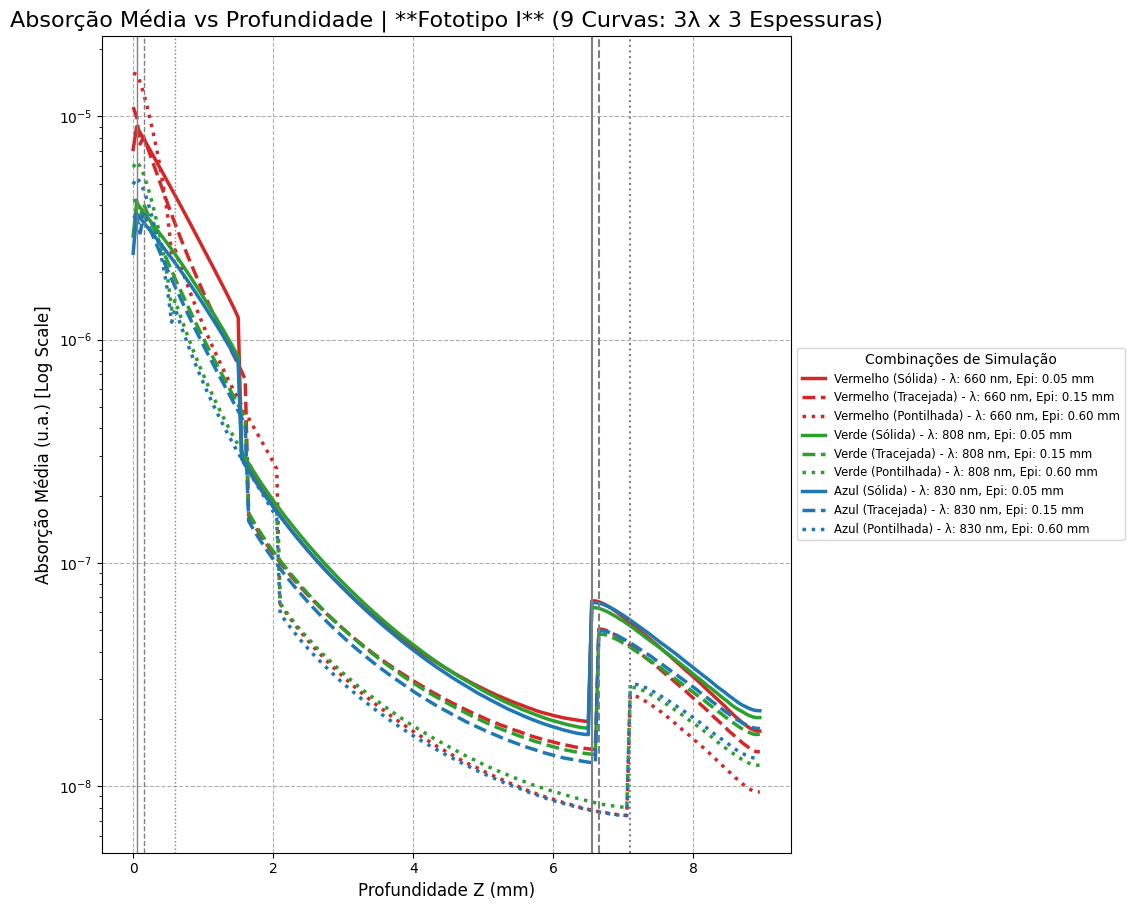

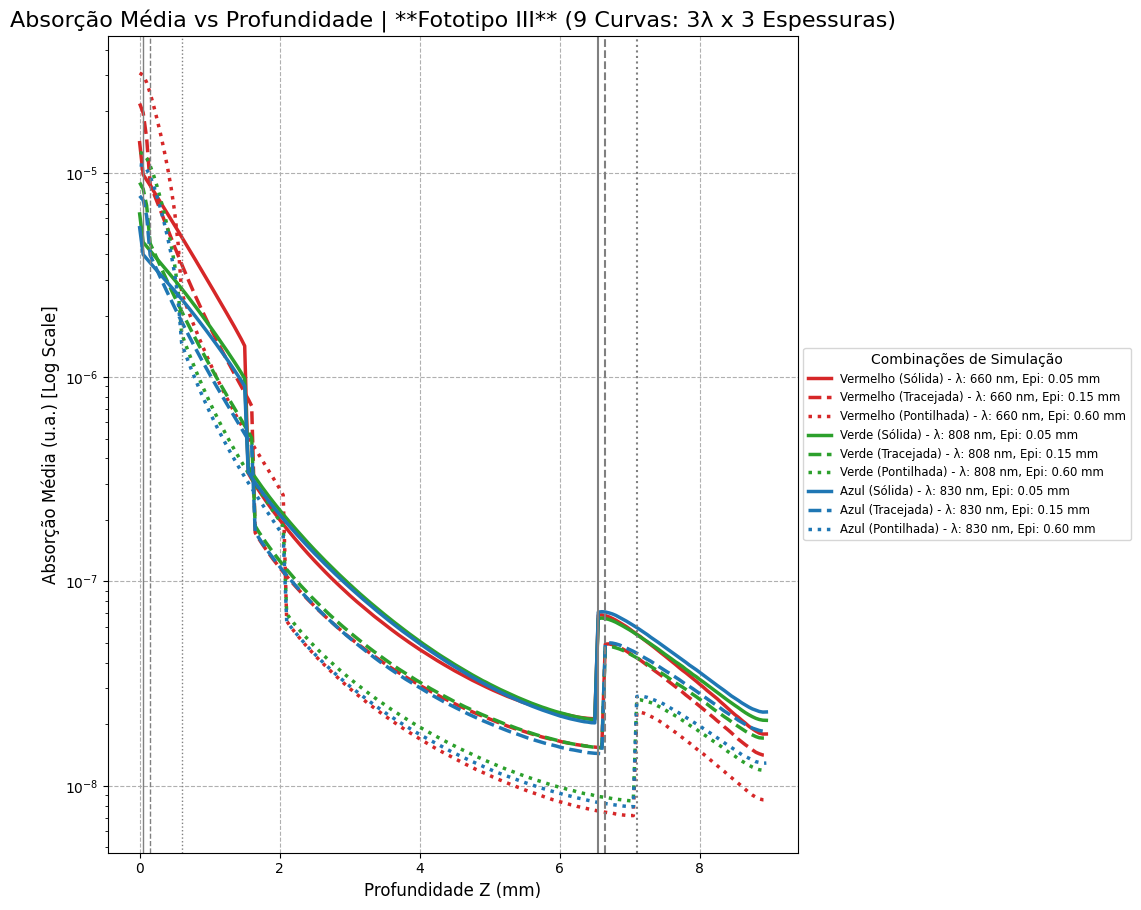

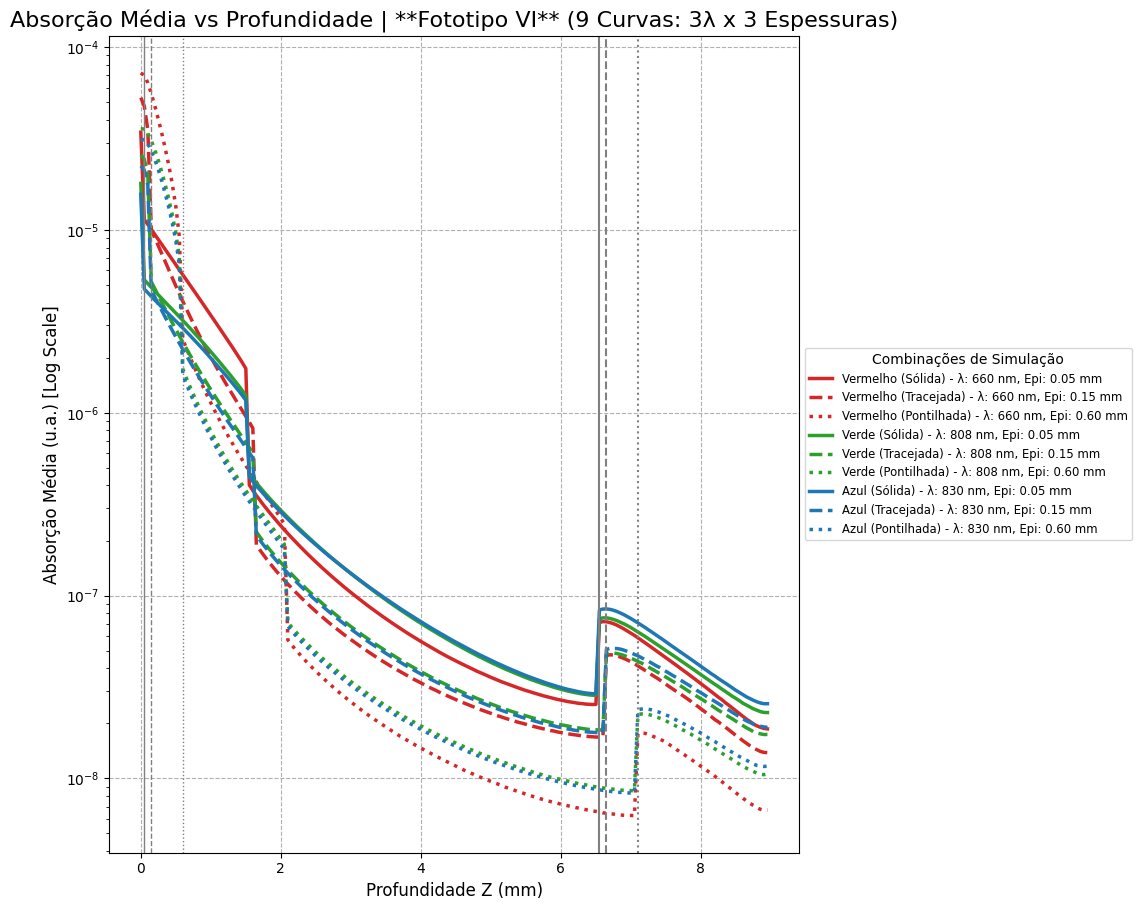

--------------------------------------------------
--- FIM DA SEÇÃO 4 ---


In [3]:
# CÉLULA 3: NOVA SEÇÃO DE RESULTADOS (SEÇÃO 4) REVISADA COM FONTES DE LEGENDA MAIORES
# MANUTENÇÃO DA SEÇÃO 4.2 E REVISÃO DA SEÇÃO 4.3

# Variáveis globais necessárias
try:
    all_sim_results
    wavelengths
    epidermis_thicknesses_mm
    voxel_size_mm
    total_size_z
    x_slice_start
    x_slice_end
    y_slice_start
    y_slice_end
    # Importações necessárias para plots
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib import cm
    import matplotlib.lines as mlines # Necessário para gerar a legenda combinada

except NameError:
    print("ERRO: Por favor, execute a Célula 1 (Simulação) primeiro para carregar os dados e variáveis.")
    raise

#-----------------------------------------------------------
# CONFIGURAÇÕES DE PLOTAGEM PARA A SEÇÃO 4 REVISADA
#-----------------------------------------------------------
fototipos_comparar = ["I", "III", "VI"]
sorted_et_mm = sorted(epidermis_thicknesses_mm)
z_axis_mm = np.arange(total_size_z) * voxel_size_mm

# Combinação de cores e estilos para diferenciar as 9 curvas (3 lambda x 3 espessuras)
# Cores para Lambda (λ)
wl_colors = {
    660: '#d62728', # Vermelho
    808: '#2ca02c', # Verde
    830: '#1f77b4'  # Azul
}
# Estilos de Linha para Espessura da Epiderme (et_mm)
et_linestyles = {
    sorted_et_mm[0]: '-',  # 0.05 mm - Sólida
    sorted_et_mm[1]: '--', # 0.15 mm - Tracejada
    sorted_et_mm[2]: ':'  # 0.60 mm - Pontilhada
}
et_labels = {
    sorted_et_mm[0]: f"{sorted_et_mm[0]:.2f} mm",
    sorted_et_mm[1]: f"{sorted_et_mm[1]:.2f} mm",
    sorted_et_mm[2]: f"{sorted_et_mm[2]:.2f} mm"
}

def plot_absorption_profile_single_plot(ft, wl, et_mm, z_axis_mm):
    """
    FUNÇÃO AUXILIAR CORRIGIDA: Agora apenas calcula e retorna o perfil de absorção
    e os dados das camadas, sem plotar, para que a plotagem possa coletar o handle.
    """

    result = all_sim_results[ft][et_mm][wl]
    energy = result['flux']

    # Cálculo do perfil de absorção médio (como na Seção 2)
    absorption_profile = np.mean(energy[x_slice_start:x_slice_end, y_slice_start:y_slice_end, :], axis=(0, 1))

    # Retorna o perfil de absorção e o dicionário de camadas
    return absorption_profile, result['layers_voxels']

# ... (Seção 4.2 inalterada) ...

#-----------------------------------------------------------
# SEÇÃO 4.3 REVISADA: Comparação Global (1 FT x 3 Lambda x 3 Espessuras = 9 Curvas/Figura)
#-----------------------------------------------------------
print("-" * 50)
print("--- SEÇÃO 4.3 REVISADA: Comparação Global 1FT (9 Curvas/Figura) ---")
print("-" * 50)

for ft in fototipos_comparar:
    # Aumento do figsize para tornar o gráfico mais "gordo" e legível
    fig, ax = plt.subplots(1, 1, figsize=(14, 10)) # De (12, 8) para (14, 10)
    ax.set_yscale('log')
    ax.grid(True, linestyle='--')
    ax.set_xlabel("Profundidade Z (mm)", fontsize='large')
    ax.set_ylabel("Absorção Média (u.a.) [Log Scale]", fontsize='large')
    ax.set_title(f"Absorção Média vs Profundidade | **Fototipo {ft}** (9 Curvas: 3λ x 3 Espessuras)", fontsize=16)

    # Dicionário para armazenar a última posição da linha da camada por espessura (para referência visual)
    last_layers = {}

    # Lista para armazenar todos os handles de plot para a legenda combinada
    all_handles = []

    # Plotar as 9 curvas
    for wl in wavelengths:
        for et_mm in sorted_et_mm:

            # --- CÁLCULO DO PERFIL DE ABSORÇÃO E CAMADAS ---
            absorption_profile, layers = plot_absorption_profile_single_plot(ft, wl, et_mm, z_axis_mm)
            # -----------------------------------------------

            # --- GERAÇÃO DE RÓTULO DESCRITIVO PARA A LEGENDA ---
            wl_nome = ""
            if wl == 660: wl_nome = "Vermelho"
            elif wl == 808: wl_nome = "Verde"
            elif wl == 830: wl_nome = "Azul"

            linestyle_nome = ""
            if et_linestyles[et_mm] == '-': linestyle_nome = "Sólida"
            elif et_linestyles[et_mm] == '--': linestyle_nome = "Tracejada"
            elif et_linestyles[et_mm] == ':': linestyle_nome = "Pontilhada"

            new_label = f"{wl_nome} ({linestyle_nome}) - λ: {wl} nm, Epi: {et_mm:.2f} mm"
            # ----------------------------------------------------------------------

            # Plota o dado retornado e coleta o handle
            line, = ax.plot(z_axis_mm, absorption_profile + 1e-18,
                            color=wl_colors[wl], linestyle=et_linestyles[et_mm],
                            linewidth=2.5, label=new_label) # linewidth ligeiramente aumentado para 2.5

            all_handles.append(line) # Adiciona o handle da linha à lista para a legenda

            # Armazena as posições das camadas para desenhar as linhas de referência mais tarde
            if wl == 830:
                last_layers[et_mm] = layers

    # Desenhar as linhas de referência das camadas (usando apenas a posição para λ=830 nm)
    if last_layers:
        for et_mm, layers in last_layers.items():
             ax.axvline(layers['Derme'][0] * voxel_size_mm,
                         color='gray', linestyle=et_linestyles[et_mm], linewidth=1)
             ax.axvline(layers['Músculo'][0] * voxel_size_mm,
                         color='gray', linestyle=et_linestyles[et_mm], linewidth=1.5)

    # Criação da Legenda Combinada
    ax.legend(handles=all_handles, title="Combinações de Simulação", loc='center left', bbox_to_anchor=(1.0, 0.5),
              fontsize='small', title_fontsize='medium')

    # Ajuste do rect para garantir que a legenda tenha espaço suficiente e o gráfico não seja comprimido
    plt.tight_layout(rect=[0, 0.03, 0.8, 0.95])
    plt.show()

print("-" * 50)
print("--- FIM DA SEÇÃO 4 ---")